<a href="https://colab.research.google.com/github/ronsegev98/Assignment_2_Group5/blob/main/Assignment_2_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment II - NLP: Seinfeld or Friends?

By: Ron Segev, Noa Shalom, Yam Almog, Dor Avrahami

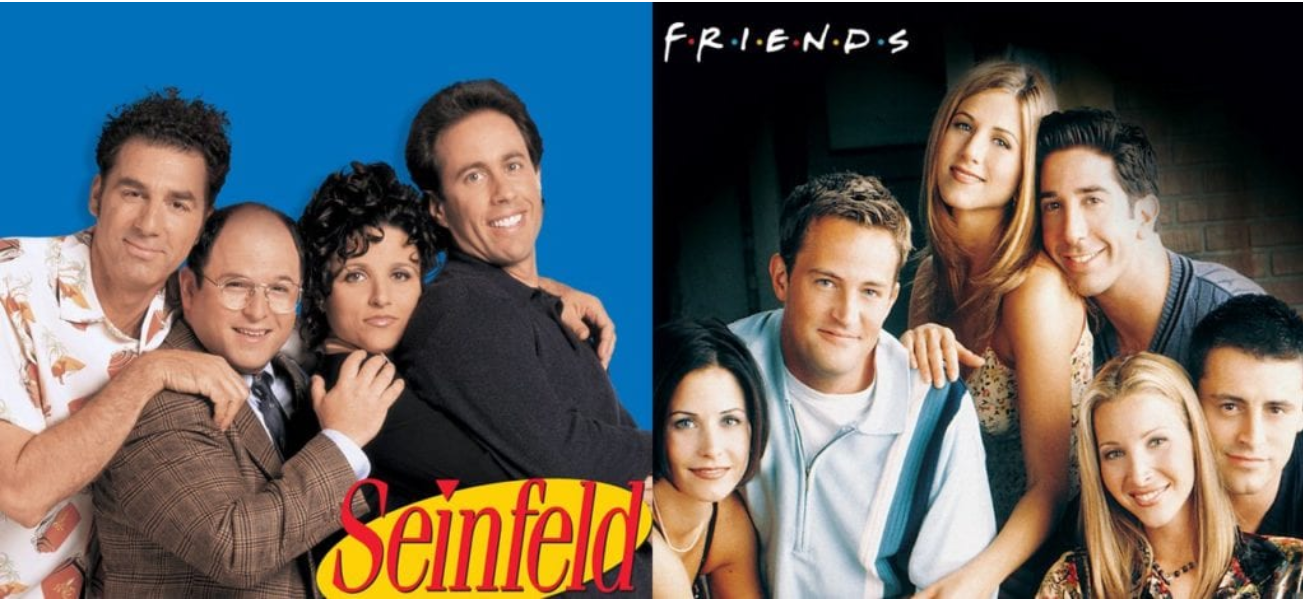

# Data Importing and Exploration

In [1]:
import pandas as pd
train_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/test.csv')


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
train_df

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
...,...,...,...,...,...
70400,Pretty much.,jerry,S05E09,Seinfeld,2
70401,"Oh, well um, not right now. Y'know I’m just g...",phoebe,Season-03 Episode-05-The One With Frank Jr.,Friends,22
70402,"Ooh, I think I wanna trade circles.",phoebe,Season-07 Episode-22-The One With Chandler’s Dad,Friends,7
70403,"Hey, hey, what is this? What's going on here?",jerry,S05E03,Seinfeld,9


In [4]:
train_df['Show'].value_counts()

Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

As can be seen here, there are more 'Friends' samples than 'Seinfeld' samples. This makes sense, as there are more characters in "Friends" (6) as there are in Seinfeld (4).

This could later effect our results, as we have more data to learn from for 'Friends'

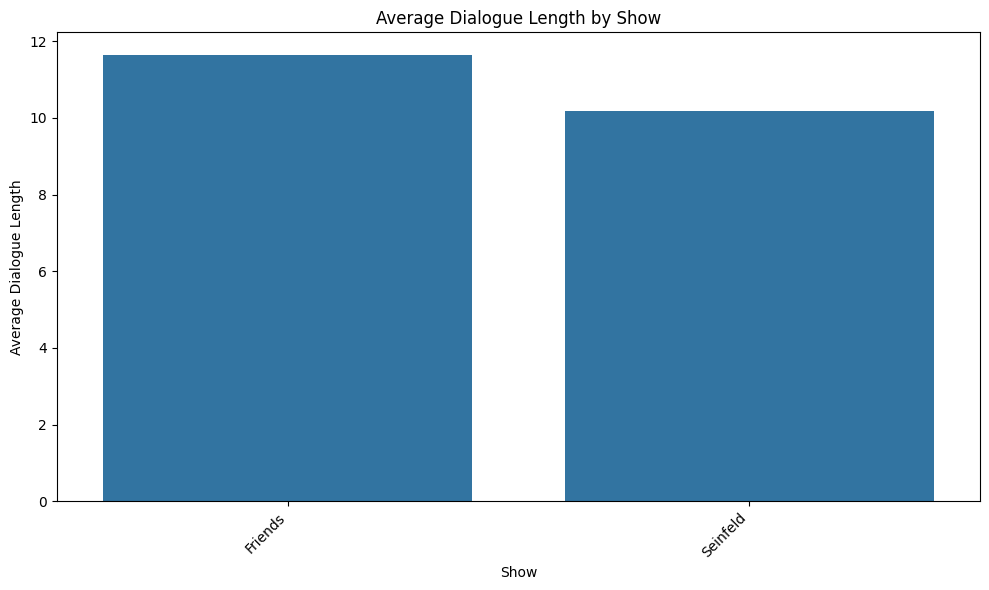

In [5]:
# Grouping the data by 'Show' and calculating the mean of 'Dialogue_length'
dialogue_lengths_by_show = train_df.groupby('Show')['Dialogue_length'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='Show', y='Dialogue_length', data=dialogue_lengths_by_show)
plt.title('Average Dialogue Length by Show')
plt.xlabel('Show')
plt.ylabel('Average Dialogue Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It can be seen that "Friends" has a larger average dialogue length. This can affect our results as our model trains on "Friends" (which as seen before is dominant in size), it might become accustomed to longer strings of text, which could affect its performance when analyzing shorter dialogues like those in "Seinfeld."

The distribution of dialogue length per show can help us later to decide what length we will use to standardize all of the data.

# Data preprocessing






In [6]:
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

import pandas as pd
import regex as re

### Removing common words between both shows

We first proceed to find and then remove common words.
This will reduce our models confusion between dialogues and can lead to an increase in model accuracy.

In [7]:
from collections import Counter
import nltk
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def get_most_common_words(df,n):
    def preprocess_text(df):
        tokens = []
        for dialogue in df['Dialogue']:
            dialogue_tokens = nltk.word_tokenize(dialogue)
            dialogue_tokens = [token.lower() for token in dialogue_tokens if token.isalpha()]
            tokens.extend(dialogue_tokens)
        return tokens

    # Filter data for each show
    friends_data = df[df['Show'] == 'Friends']
    seinfeld_data = df[df['Show'] == 'Seinfeld']

    # Process the dialogues for each show
    tokens_friends = preprocess_text(friends_data)
    tokens_seinfeld = preprocess_text(seinfeld_data)

    # Count word frequencies for each show
    freq_friends = Counter(tokens_friends)
    freq_seinfeld = Counter(tokens_seinfeld)

    # Find common words between the two shows
    common_words = set(freq_friends).intersection(set(freq_seinfeld))

    # Find the most common words across both shows
    most_common_words = sorted(common_words, key=lambda word: freq_friends[word] + freq_seinfeld[word], reverse=True)[:n]

    return most_common_words

def remove_most_common_words(df, most_common_words):
    #remove words
    def remove_words(dialogue):
        tokens = nltk.word_tokenize(dialogue)
        tokens = [token for token in tokens if token.lower() not in most_common_words]
        return ' '.join(tokens)

    # Remove most common words from each dialogue
    df['Cleaned_Dialogue'] = df['Dialogue'].apply(remove_words)
    return df


# Get the 20 most common words across both shows
most_common_words = get_most_common_words(train_df, 20)

# Remove these words from the 'Dialogue' column
train_df_cleaned = remove_most_common_words(train_df, most_common_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
most_common_words

['i',
 'you',
 'the',
 'to',
 'a',
 'it',
 'that',
 'and',
 'what',
 'do',
 'oh',
 'is',
 'of',
 'in',
 'this',
 'know',
 'me',
 'no',
 'he',
 'yeah']

These are the words that we removed. It can be seen that many of these are stop words, so there is no need to remove them again. Further along in our tests we even noticed that removing stop words using the known function reduced our accuracy

### Text Cleanup

We now proceed to use regex functions to clean up the text

We noticed that the text contains many special characters, such as "()", "[]", "*", and "{}" as seen below.


In [9]:
# Define a regular expression pattern to check for square brackets, curly brackets, parentheses, or asterisks
pattern = r'[\[\]()*{}]'

# Use str.contains to check for the pattern in the 'dialogue_feature' column
train_df_cleaned['special_characters_present'] = train_df_cleaned['Cleaned_Dialogue'].str.contains(pattern)


# Check if there is at least one True value
if train_df_cleaned['special_characters_present'].any():
    print("At least one entry contains special characters.")
else:
    print("No entry contains special characters.")


# Filter rows where 'special_characters_present' is True
samples_with_true = train_df_cleaned[train_df_cleaned['special_characters_present']]

# Display the samples with True
samples_with_true.head()

At least one entry contains special characters.


,Dialogue,Character,Episode,Show,Dialogue_length,Cleaned_Dialogue,special_characters_present
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13,( Joey ) Are gon na be embarrassed going up th...,True
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56,Alright guys are off party number one [ ushers...,True
7,"(over-enthusiastic) I don't know, I don' I do...",chandler,Season-09 Episode-15-The One With The Mugging,Friends,27,"( over-enthusiastic ) n't , don ' don ' ! was ...",True
8,I know. *He* always wanted to be the first bl...,chandler,Season-10 Episode-15-The One Where Estelle Dies,Friends,15,. * * always wanted be first black man cross A...,True
10,(gets up and opens the door) Hi Tag! What are...,rachel,Season-07 Episode-08-The One Where Chandler Do...,Friends,13,( gets up opens door ) Hi Tag ! are doing here ?,True


After testing our model's accuracy multiple times removing/not removing these characters, we concluded that the following actions lead us to the highest accuracy

In [10]:
def clean_text(text):

    #lower case
    text = text.lower()

    # Regex to remove parentheses
    pattern1 = r"\(|\)"
    cleaned_text = re.sub(pattern1, "", text)

    # Regex to remove "[]" parentheses
    pattern2 = r"\[.*?\]"
    cleaned_text = re.sub(pattern2, "", cleaned_text)

    # Regex to remove "*"
    cleaned_text = re.sub(r"\*", "", cleaned_text)



    return cleaned_text



In [11]:
train_df_cleaned['Cleaned_Dialogue'] = train_df_cleaned['Cleaned_Dialogue'].apply(clean_text)

In [12]:
pd.set_option('display.max_colwidth', None)

train_df_cleaned.head()

,Dialogue,Character,Episode,Show,Dialogue_length,Cleaned_Dialogue,special_characters_present
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1,hey .,False
1,(to Joey) Are you gonna be embarrassed going up there having nothing prepared?,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13,joey are gon na be embarrassed going up there having nothing prepared ?,True
2,"Me? No no no, you. You're gonna tell him. I'm not gonna tell- Noo.",elaine,S03E22,Seinfeld,14,"? , . 're gon na tell him . 'm not gon na tell- noo .",False
3,"Alright you guys are off to party number one [ushers 3 guys into Monica's apartment] and you, you are off to party number two [ushers four women into his apartment. Two guys try to follow and Chandler blocks them and shoos them off to Monica's apartment] Alright fellas, let's keep it movin', let' keep it movin.",chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56,"alright guys are off party number one , are off party number two alright fellas , let 's keep movin ' , let ' keep movin .",True
4,Am I? Or am I so sane that you just blew your mind?,kramer,S05E12,Seinfeld,13,am ? or am so sane just blew your mind ?,False


As seen above, we initiated the following changes:

    1. Made everything lowercase letters.

    2. removing "()" brackets (not the words inside as they contain context specific to the show).

    3. "[]" brackets and all contained words, as they are stage directions.
    
    4. Removing "*", since it can confuse the context of a sentence.


# Train/Validation Split

In [13]:
X = train_df_cleaned['Cleaned_Dialogue']
Y = train_df_cleaned['Show']

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
train_label_count = y_train.value_counts()
test_label_count = y_val.value_counts()

print('Train Seinfeld to Friends dialogue ratio:', train_label_count['Seinfeld'] / train_label_count['Friends'])
print('Test Seinfeld to Friends dialogue ratio:', test_label_count['Seinfeld'] / test_label_count['Friends'])

Train Seinfeld to Friends dialogue ratio: 0.7998913495030837
Test Seinfeld to Friends dialogue ratio: 0.805487883061931


When check that our labels are balanced, we see that they are not.
This is in line with the fact that we have more 'Friends' dialogue (and characters) as seen before.


# Deep Learning Prep

In [15]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)

x_train_dl = token.texts_to_sequences(x_train)
x_val_dl = token.texts_to_sequences(x_val)


We converted our show labels to binary so we can properly input them into our model.

In [16]:

def convert_labels(df, label_mapping):
    df = df.replace(label_mapping)
    return df

label_mapping = {"Seinfeld": 0, "Friends": 1}
y_train = convert_labels(y_train, label_mapping)
y_val = convert_labels(y_val, label_mapping)

y_train

52400    0
65083    0
6914     1
39036    1
12969    1
        ..
37194    0
6265     0
54886    0
860      0
15795    0
Name: Show, Length: 56324, dtype: int64

In [17]:
y_val

37642    1
37017    1
62909    1
58519    1
6232     0
        ..
24988    1
44310    0
12216    1
39468    1
21317    1
Name: Show, Length: 14081, dtype: int64

Since we preprocessed our data heavily, the "Dialogue_length" column is no longer relevant. We calculated our new min,max, and average dialogue length to get a sense of scale for our model.

In [18]:
doc_len_list = [len(doc) for doc in x_train_dl]

max(doc_len_list), min(doc_len_list), np.mean(doc_len_list)

(256, 0, 8.490714437895036)

<Axes: ylabel='Count'>

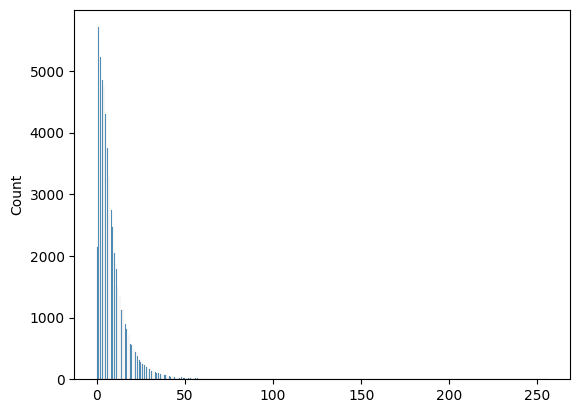

In [19]:
sns.histplot(doc_len_list)

Based on these results and extensive testing, we reached a conclusion that max_words = 100 was the best result for padding as far as accuracy goes.

In [20]:
max_words = 100

x_train_dl = sequence.pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = sequence.pad_sequences(x_val_dl, maxlen=max_words)

In [21]:
x_train_dl.shape

(56324, 100)

In [22]:
x_val_dl.shape

(14081, 100)

In [23]:
x_train_dl[10, :]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,   87,  449,  101,    4,  928,  257,  459,   32,
         34,  184, 2247,   54,   32, 7721, 6203,  276,  107,  103,   34,
        459], dtype=int32)

In [24]:
#For model input dim
total_words = len(token.word_index) + 1
total_words

19350

As can be seen above, our data is ready for deep learning models.

# Deep Learning Models

Lets create a DL model for our NLP problem

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout,GlobalMaxPooling1D,Activation
from keras.layers import BatchNormalization

In [26]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=128, input_length=max_words))
model.add(Conv1D(128, 1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2476800   
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          16512     
                                                                 
 batch_normalization (Batch  (None, 100, 128)          512       
 Normalization)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0

Let's break down the model layer by layer to understand its structure and the reasons for choosing this architecture for the given task:

Embedding Layer: The Embedding layer is the first layer of the model, transforming the input data (text) into dense vectors of fixed size, in this case, 128 dimensions. input_dim is the size of the vocabulary (total number of unique words in the dataset), and input_length is the length of input sequences. This layer is crucial for our NLP task as it provides a way to represent words in a meaningful way, capturing semantic similarities between them.

Conv1D Layer: This layer applies 128 convolution filters (of size 1) to the embedded word vectors. The use of padding='same' ensures the output has the same length as the input by padding it, and activation='relu' introduces non-linearity to the model. Conv1D layers are effective in processing sequences (like sentences) by capturing local patterns (like phrases indicative of each show's style).

BatchNormalization Layer: This layer normalizes the activations of the previous layer, ensuring that the network trains efficiently. It stabilizes the learning process and significantly reduces the number of training epochs required to train deep networks.

GlobalMaxPooling1D Layer: This layer reduces the dimensionality of the input. It helps the model to capture the most important feature for each feature map and reduces overfitting.

Dense Layer (64 neurons): After flattening the features, this layer is a fully connected layer with 64 neurons and activation='relu', which adds further non-linearity to the model, allowing it to learn complex patterns.

Dropout Layer (0.5): This layer randomly sets input units to 0 with a frequency of 0.5 at each step during training, helping to prevent overfitting by ensuring that the model does not rely too much on any single node.

Dense Layer (1 neuron): The final layer is a fully connected layer with a single neuron and activation='sigmoid', which outputs a value between 0 and 1, representing the probability that the given input belongs to one class (in our case the relevant show). The use of the sigmoid activation function makes this model suitable for binary classification tasks.

Compilation: The model uses the binary_crossentropy loss function, suitable for a binary classification problem like ours. The adam optimizer is chosen for its efficiency in adjusting the learning rate and its suitability for a wide range of problems. The model's performance is evaluated based on accuracy.

This architecture is chosen for our NLP problem because it combines the power of word embeddings to capture semantic similarities, convolutional layers to identify local patterns within sentences, and dense layers to make classification decisions based on these patterns. The use of dropout and batch normalization helps in preventing overfitting and ensures that the model generalizes well to unseen data. This setup is particularly effective for distinguishing between the styles of "Seinfeld" and "Friends", as it can learn the unique linguistic features and patterns that are characteristic of each show's scripts.


In [28]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=20, callbacks=[early_stopping],batch_size=64)

# Access training accuracy from the history object
training_accuracy = history.history['accuracy']




Epoch 1/20
881/881 [==============================] - 27s 25ms/step - loss: 0.4855 - accuracy: 0.7316 - val_loss: 0.4372 - val_accuracy: 0.7657
Epoch 2/20
881/881 [==============================] - 8s 9ms/step - loss: 0.3910 - accuracy: 0.8005 - val_loss: 0.4354 - val_accuracy: 0.7651
Epoch 3/20
881/881 [==============================] - 6s 7ms/step - loss: 0.3420 - accuracy: 0.8290 - val_loss: 0.4586 - val_accuracy: 0.7697
Epoch 4/20
881/881 [==============================] - 7s 8ms/step - loss: 0.3083 - accuracy: 0.8429 - val_loss: 0.4671 - val_accuracy: 0.7702
Epoch 5/20
881/881 [==============================] - 6s 7ms/step - loss: 0.2865 - accuracy: 0.8530 - val_loss: 0.5249 - val_accuracy: 0.7689


The early stopping mechanism is implemented as a precaution to mitigate the risk of overfitting. By monitoring the validation loss and setting a patience of three epochs, the training process is designed to halt before significant overfitting can occur. This approach aims to preserve the model's generalization ability by ensuring that we retain the model weights from the epoch with the best performance on the validation set, as indicated by the lowest validation loss. This approach also saves computation time/resources.




### Model Evaluation on Test Set

Preprocess test data using learned values from train

In [29]:
def preprocess_test(test_df,most_common_words,label_mapping,max_words,token):

  # remove common words from the 'Dialogue' column
  test_df = remove_most_common_words(test_df, most_common_words)

  #clean dialogue

  test_df['Cleaned_Dialogue'] = test_df['Cleaned_Dialogue'].apply(clean_text)

  #create x,y

  x_test = test_df['Cleaned_Dialogue']
  y_test = test_df['Show']

  #tokens

  x_test = token.texts_to_sequences(x_test)

  #binary labels
  y_test = convert_labels(y_test,label_mapping)

  #padding
  x_test = sequence.pad_sequences(x_test, maxlen=max_words)

  return x_test,y_test

x_test,y_test = preprocess_test(test_df,most_common_words,label_mapping,max_words,token)

Evaluation of test set

In [30]:
test_ac = model.evaluate(x_test, y_test)

133/133 [==============================] - 0s 3ms/step - loss: 0.2812 - accuracy: 0.8657


After extensive preprocessing and model engineering, these results on our test set are very good!

# Evaluating Results per Character

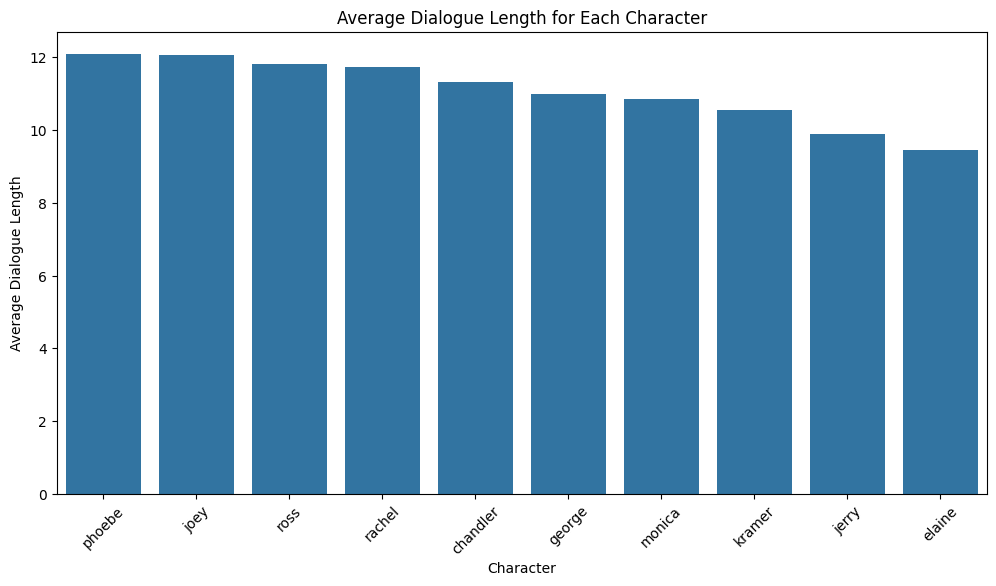

In [31]:
# Calculate the average dialogue length for each character
average_dialogue_length = train_df_cleaned.groupby('Character')['Dialogue_length'].mean().reset_index()

# Sort the characters by average dialogue length in descending order
sorted_df = average_dialogue_length.sort_values('Dialogue_length', ascending=False)

#plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Character', y='Dialogue_length', data=sorted_df)
plt.title('Average Dialogue Length for Each Character')
plt.xlabel('Character')
plt.ylabel('Average Dialogue Length')
plt.xticks(rotation=45)
plt.show()

First, we plotted the average dialogue length per character. As seen in the beginning, this is consistent with the fact that Friends has longer dialogues on average compared to Seinfeld.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'jerry'),
  Text(1, 0, 'george'),
  Text(2, 0, 'ross'),
  Text(3, 0, 'rachel'),
  Text(4, 0, 'joey'),
  Text(5, 0, 'chandler'),
  Text(6, 0, 'elaine'),
  Text(7, 0, 'monica'),
  Text(8, 0, 'phoebe'),
  Text(9, 0, 'kramer')])

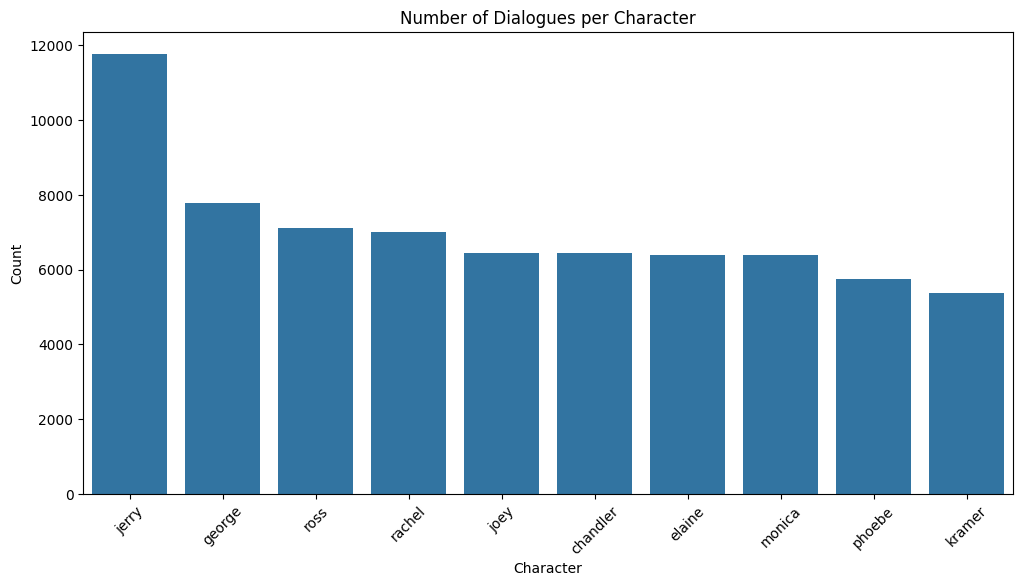

In [32]:
character_counts = train_df_cleaned['Character'].value_counts().reset_index()
character_counts.columns = ['Character', 'Count']


plt.figure(figsize=(12, 6))
sns.barplot(x='Character', y='Count', data=character_counts)
plt.title('Number of Dialogues per Character')
plt.xlabel('Character')
plt.ylabel('Count')
plt.xticks(rotation=45)



The above graph shows the amount of dialogue per character. This might provide explainability for our results later.

We will now show how well our model performs per character per show

In [33]:
def evaluate_model_by_character(model,accuracy_results,characters,most_common_words,label_mapping,max_words,token):

    for character in characters:
        #load test and filter per character
        test_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/test.csv')
        test_df = test_df[test_df["Character"] == character]
        #preprocess
        x_test,y_test = preprocess_test(test_df,most_common_words,label_mapping,max_words,token)



        # Predict using the model and store in dict per character
        evaluation_results = model.evaluate(x_test, y_test)
        accuracy_results[character] = evaluation_results[1]

    #sort dict by values
    accuracy_results = {k: v for k, v in sorted(accuracy_results.items(), key=lambda item: item[1],reverse=True)}

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(accuracy_results)), list(accuracy_results.values()), align='center')
    plt.xticks(range(len(accuracy_results)), list(accuracy_results.keys()), rotation=45)
    plt.xlabel('Character')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Character')
    plt.show()

    return accuracy_results

15/15 [==============================] - 0s 3ms/step - loss: 0.2290 - accuracy: 0.8863


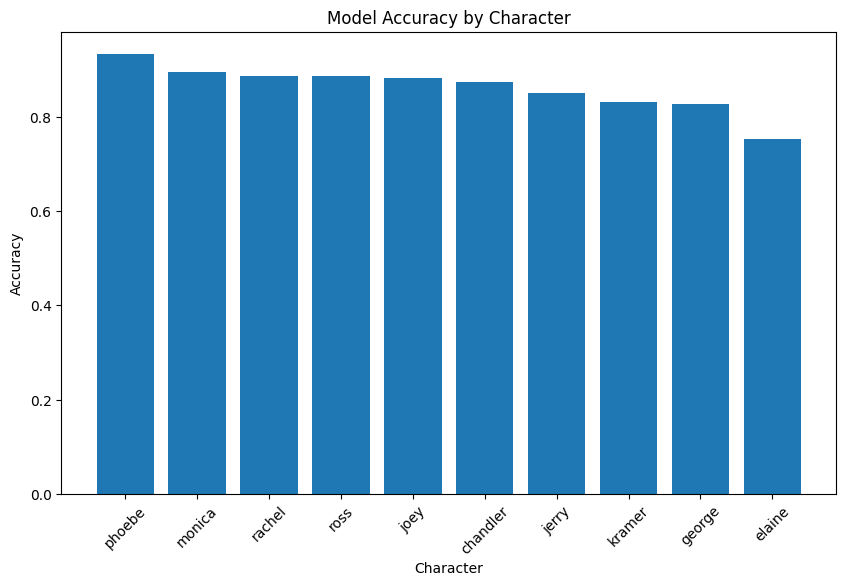

In [34]:
test_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/test.csv')

#create character list
characters = np.unique(test_df["Character"])
characters = characters.tolist()

#add list to dict for accuracy
accuracy_results = {}
for character in characters:
    accuracy_results[character] = 0

accuracy_results_new = evaluate_model_by_character(model,accuracy_results,characters,most_common_words,label_mapping,max_words,token)

In [35]:
accuracy_results_new

{'phoebe': 0.9340101480484009,
 'monica': 0.8952879309654236,
 'rachel': 0.887445867061615,
 'ross': 0.8863157629966736,
 'joey': 0.883474588394165,
 'chandler': 0.8734793066978455,
 'jerry': 0.8517887592315674,
 'kramer': 0.8310810923576355,
 'george': 0.8270041942596436,
 'elaine': 0.7534246444702148}

In [36]:
# Find the character with the highest accuracy
max_character = max_key = max(accuracy_results, key=accuracy_results.get)
max_accuracy = accuracy_results[max_character]

# Find the character with the lowest accuracy
min_character = min(accuracy_results, key=lambda k: accuracy_results[k])
min_accuracy = accuracy_results[min_character]

In [37]:
max_character,max_accuracy

('phoebe', 0.9340101480484009)

In [38]:
min_character,min_accuracy

('elaine', 0.7534246444702148)


As can be seen above, the characters with the highest and lowest accuracy are phoebe and elaine respectively.

Phoebe has words in her lines that repeat themselves and are unique to her character, which can be an explanation for her higher accuracy. In addition, characters with longer average dialogues (like Phoebe) might provide more context for the model to make accurate predictions.

The lower accuracy for characters like Elaine could be due to various reasons such as less dialogue data to learn from (as seen in the graph above), more ambiguous dialogue, or perhaps their dialogue does not follow patterns as closely as other characters.

The total number of rows (or amount of dialogue) for each character may also affect the model's accuracy since more data can lead to better learning and thus better prediction accuracy. However, Jerry, who has the most dialogue, does not have the highest accuracy, suggesting that other factors also play a role.



# Export Results To CSV

In [39]:
from keras import backend as K

trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])

number_of_layers = len(model.layers)

num_epochs = len(history.epoch)



In [40]:
model_details = {
    'Test Set Accuracy': test_ac[1],
    'Train Set Accuracy': training_accuracy[-1],
    'Number of Trainable Parameters': trainable_params,
    'Number of Layers': number_of_layers,
    'Regularization Methods': ['dropout, batch normalization'],
    'Number of Epochs': num_epochs,
    'Choice of Loss Function': ['binary_crossentropy'],
    'Choice of Optimizer': ['Adam'],
    'Embedding Dimension': [128]
}


model_df = pd.DataFrame([model_details])


model_df.to_csv('exercise3.csv', index=False)
